# Revealing Subreddits: Unraveling Topic Clusters in Reddit Posts

## Executive Summary
Reddit is a social website where people share and discuss various contents and topics. The website is organized into "subreddits" which are communities within Reddit that discuss specific topics, media, articles or contents. With a website producing such amount of content, this project aims to unravel the topic clusters given a sample of post titles.

TFIDF Vectorizer was used to transform the post titles to bag of words. After several tests and validation tools, K-Means clustering was the chosen representative-based clustering algorithm, which used the truncated singular value decomposition dataset, with 80% of information retained. After clustering, we have determined the themes that are prominent in each group. 

### Highlights
1. K-means and K-medians clustering algorithms were used, but after validation tests, K-means was the final model that was used for clustering.
2. $k$ = 5 was determined to be the optimal cluster in this process
3. Below are the topic clusters:

| Cluster | Identified Topic/Theme | Frequent Term/s |
|:-------:|:---------------:|:--------------:|
|1| Donald Trump/Republican	|donald, trump, rally|
|2| TIL - Today I Learned |	til|
|3| Clinton/Sanders/Democrats|	sanders, bernie, clinton, hillary|
|4|	Leisure/Celebrations |	new, year, happy, york, first|
|5|	Foreign Words/Topics/Vietnam |	ngon, cach, trung, lam, sao, mon|

## Table of Contents
1. Data Description
2. Data Processing
3. Exploratory Data Analysis
4. Models
    - Vector Representation
    - Dimensionality Reduction
    - Clustering
    - Internal Validation
    - Choosing K
5. Results and Recommendations
6. References
7. Acknowledgements
8. Git Repository Link

## Data Description
The dataset contains 6000 samples of post titles and authors (if available) from Reddit, a social news aggregation, content rating and discussion website. The file `reddit-dmw-sample.txt` containing this data was provided in class.

First, let us import all the libraries that we need to successfully run this notebook.

In [42]:
# Libraries / Preliminaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from itertools import chain
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cityblock
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn_extensions.fuzzy_kmeans import KMedians
%matplotlib inline

## Data Processing
Upon inspection of the file, it can be seen that the data is delimited by tabs. As such, we have stored the data into a `reddit_data` pandas DataFrame and used tab as its separator in the parameters.

In [17]:
reddit_data = pd.read_csv('reddit-dmw-sample.txt', sep='\t', index_col=0)
reddit_data.head()

,author,title
0,PrimotechInc,7 Interesting Hidden Features of apple ios9
1,xvagabondx,Need an advice on gaming laptop
2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...
3,Philo1927,Microsoft Plumbs Ocean’s Depths to Test Underw...
4,tuyetnt171,OPPO F1 chính hãng - Fptshop.com.vn


A quick look on the dataframe will reveal that the data is not so clean. As we are primarily concerned with unraveling the topic clusters in this dataset, we will focus our cleaning on the title column. The following steps were thus made into the data to further clean it:
- setting of title texts to lowercase
- removal of duplicate titles
- removal of punctuations
- stripping of leading and trailing whitespaces
- removal of texts with two characters or less

In [18]:
reddit_data = reddit_data.apply(lambda x: x.str.lower())
reddit_data = reddit_data.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
reddit_data['title'] = reddit_data['title'].str.strip()
reddit_data['title'] = reddit_data['title'].str.replace('[/.]',' ')
reddit_data['title'] = reddit_data['title'].str.replace('[^\w\s]','')

In [21]:
reddit_data.head()

,author,title
0,primotechinc,7 interesting hidden features of apple ios9
1,xvagabondx,need an advice on gaming laptop
2,nkindustries,semi automatic ropp capping machine ropp cap...
3,philo1927,microsoft plumbs oceans depths to test underwa...
4,tuyetnt171,oppo f1 chính hãng fptshop com vn


We have reduced our data from from 6000 rows to 5848 rows. As per checking, it appears that we now have a cleaner dataset. Let us now do some data exploration.

## Exploratory Data Analysis
Let us try to check first the most frequently appearing words in the titles column. The horizontal bar graph below shows the fifteen most frequently appearing words in the title column of the `reddit_data` DataFrame. We will use the `top_words` and `plot_top_words` functions below for this purpose.

In [399]:
def top_words(text, n=None, ngram = (1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range= ngram, lowercase=True).fit(text)
    bows = vec.transform(text)
    total_words = bows.sum(axis=0) 
    word_count = [(word, total_words[0, idx]) for word, idx in  vec.vocabulary_.items()]
    word_count =sorted(word_count, key = lambda x: x[1], reverse=True)
    return word_count[:n]

In [400]:
def plot_top_words(text, title, n=20):
    top = top_words(text,n)
    top_n_words = []
    top_n_counts = []
    for i in range(len(top)):
        top_n_words.append(top[i][0])
        top_n_counts.append(top[i][1])
        
    plt.figure(figsize=(9,6))
    plt.bar(top_n_words, top_n_counts, color = "#9ADDE8")
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xticks(rotation = 60)
    plt.tight_layout()

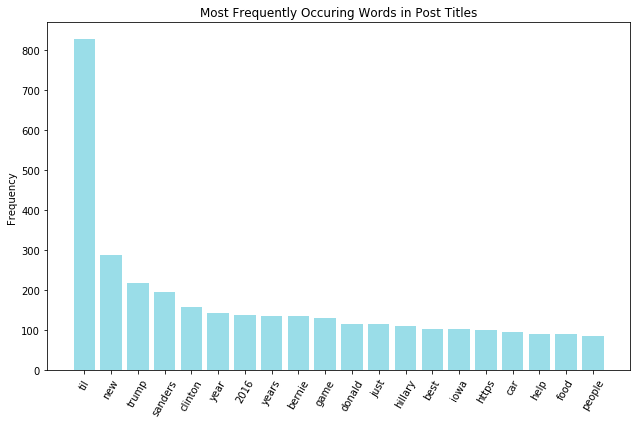

In [403]:
plot_top_words(reddit_data['title'], 'Most Frequently Occuring Words in Post Titles')

To help us visualize better, below on the other hand is a word cloud representation of the most frequently appearing words in the dataset. 

In [388]:
wordcloud_list = []
for each in reddit_data['title'].dropna():
    temp = re.findall('\w[\w-]+', each)
    temp_list = []
    for why in temp:
        temp_list.append(re.sub('\s', '-', why))
    wordcloud_list += temp_list

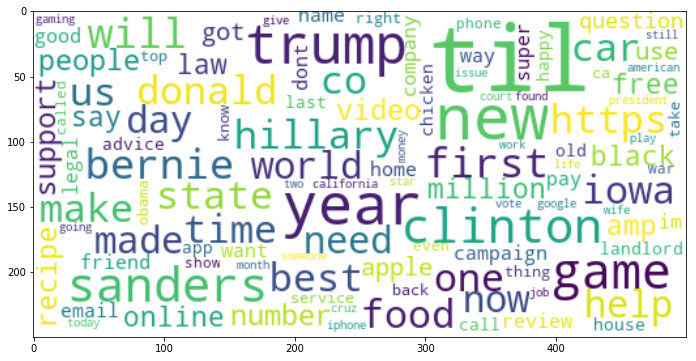

In [389]:
text = ' '.join(wordcloud_list)

wc = WordCloud(background_color="white", max_words=2000, 
               max_font_size=70, random_state=42, regexp='[^\s]+',
              min_font_size=8, width=500, height=250,
              collocations=False)
wc.generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.show()

From the word cloud above, we can see that the post titles vary in topics. The biggest word is 'til', which pertains to the 'TIL - Today I Learned' subreddit. Reddit members use TIL in post titles whenever they share some new learnings or something that may be of great interest to the readers.


Reddit members use TIL in the titles of their postings when they discover something amazing about the world; for example, something that contradicts common knowledge or a fact that is particularly important and of interest to readers.

Other prominent words are 'trump', 'clinton', 'new' and 'year' which most probably are topics related to politics and celebrations.

Let us now try to cluster these words to help us unravel the topic clusters in this dataset.

## Models

### Vector Representation
For us to successfully analyze texts and apply clustering techniques to it, we first have to create representations and convert our data into a numerical form.

Now, shoud we use `CountVectorizer` or `TFIDFVectorizer`? As `CountVectorizer` seems to just count the word frequencies, we will be using `TFIDFVectorizer` here. `TFIDFVectorizer` makes use of an idf-transformer which normalizes the frequencies by scaling down the impact of words that are frequently occuring. In general, TF-IDF or Term Frequency-Inverse Document Frequency is a measure that tells us how important a word is in a document or collection.

Below, we have used `english` stop_words as our parameter.

In [32]:
vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', stop_words='english')
bows = vectorizer.fit_transform(reddit_data['title'])
X = bows.todense()
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,12444,12445,12446,12447,12448,12449,12450,12451,12452,12453
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionality Reduction
We want to reduce the dimensions of the dataset given its high dimensionality which may cause issues. As such, we will now determine the number of components of the data that will give at least, ideally 80% of the explained variance of the data. Here, We will be using Latent Semantic Analysis (LSA) through the use of Singular Value Decomposition (SVD) to reduce the number of features.

Using 2,500 components, we can see that we have retained 80.47% of the information. We will be using this number of components for our clustering.

In [33]:
svd = TruncatedSVD(n_components=2500, random_state=1337)
X_svd = svd.fit_transform(bows)
print('Explained Variance using 2500 components: {}'.format(svd.explained_variance_ratio_.sum()))

Explained Variance using 2500 components: 0.8047428667152473


Further, we have used TSNE below to help us visualize our dataset which happen to have high dimensionality. We will be using the same method later on to help us visualize the clustering in various values of $k$.

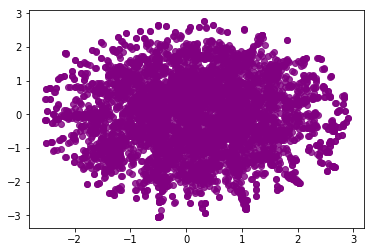

In [34]:
X_new = TSNE(random_state=1337, perplexity=300).fit_transform(X_svd)
plt.scatter(X_new[:,0], X_new[:,1], c='purple', alpha=0.8);

### Clustering
In this section, we will try to explore the possible clustering of the Reddit post titles using the k-means and k-medians algorithms. The two algorithms are very much similar. K-medians is a variation of k-means clustering which calculates the median for each cluster to determine its centroid, instead of using the mean.

The goal here is to be able to divide the dataset into $k$ clusters, and for us to determine the most appropriate number of $k$ that shall result to the most optimal clustering. In  k-means, the centroid is the mean of points in the cluster, while fork-medians, the centroid is the median of the points in the cluster.

For visualization purposes, we tried to cluster using K-Means. We looped through k-values from 2 to 11, which we will further test through the internal validation metrics below, along with the cluster we will make through K-Medians.

In [436]:
def kmeans_cluster_search(X):
    """Implement KMeans on varying number of k clusters
    
    Parameters
    ----------
    X : DataFrame
        vector of features
        
    Returns
    -------
    inertias, iidrs, scs: lists
        lists of internal validation values
    """
    X = pd.DataFrame(X)
    fig, ax = plt.subplots(2, 5, dpi=150, sharex=True, sharey=True, figsize=(7,4),
                           subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01));
    inertias = []
    iidrs = []
    scs = []
    
    for i in range(2, 12):
        kmeans = KMeans(n_clusters=i, random_state=168)
        y = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        iidrs.append(intra_to_inter(X.values, y, euclidean, 50))
        scs.append(silhouette_score(X, y))
        
        if i < 7:
            ax[0][i%7-2].scatter(X[0], X[1], s=12, c=y, alpha=0.8, marker='.');
            ax[0][i%7-2].set_title('$k=%d$'%i);
        else:
            ax[1][i%7].scatter(X[0], X[1], s=12, c=y, alpha=0.8, marker='.');
            ax[1][i%7].set_title('$k=%d$'%i);
    
    return inertias, iidrs, scs, ax

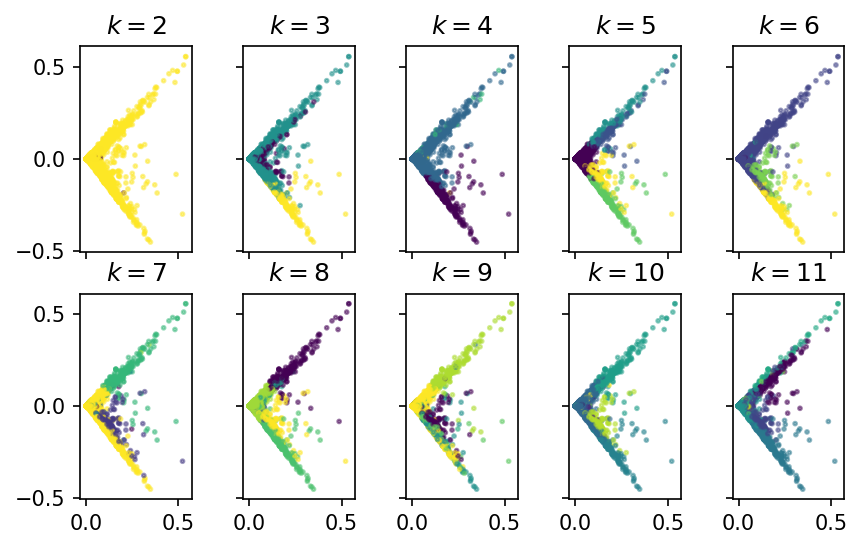

In [437]:
inertias, iidrs, scs, ax = kmeans_cluster_search(X_svd)
ax;

### Internal Validation
The `intra_to_inter` function below will be used to compute the intra-inter ratio.

In [35]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Data matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    dist_P = []
    dist_Q = []
    np.random.seed(11)
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        # just skip the pair even if we end up having pairs less than r
        if i == j:
            continue
        # intracluster
        elif y[i] == y[j]:
            dist_P.append(dist(X[i], X[j]))
        # intercluster
        else:
            dist_Q.append(dist(X[i], X[j]))
    intra = np.sum(dist_P) / len(dist_P)
    inter = np.sum(dist_Q) / len(dist_Q)
    ratio = intra / inter
    return ratio

To help us identify the optimal number of $k$ clusters, we will use the following internal cluster validation metrics:

- **Sum of Squares Distances to centroids (SSE):** This measure corresponds to the sum of squares distances to the representative points. The smaller the distances suggest there is a better clustering and that the data points are more clumped. 
- **Calinski-Harabasz index (CH):** This is also known as the Variance Ratio Criterion which is the ratio of the between-clusters dispersion mean and the within-cluster dispersion. The higher the value of this measure, the more defined the clusters are.
- **Intracluster to intercluster distance ratio (IIDR):** This is the ratio of the average distance of pairs that belong to the same cluster, and the average distance of pairs that belong to different cluster. Small values of this measure indicate better clustering behavior. 
- **Silhouette coefficient (SCS):** Values here range from -1 to 1 where 1 means there is good separation among clusters and -1 indicates some level of intersection between clusters.

In general, we want to get small values for SSE and IIDR and high values for SCS and CH to ensure a good clustering.

#### K-Means on SVD

In [167]:
inertias_ksvd = []
iidrs_ksvd = []
scs_ksvd = []
chs_ksvd = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=1337, n_jobs=-1)
    y = kmeans.fit_predict(X_svd)
    inertias_ksvd.append(kmeans.inertia_)
    iidrs_ksvd.append(intra_to_inter(X_svd, y, euclidean, 50))
    scs_ksvd.append(silhouette_score(X_svd, y))
    chs_ksvd.append(calinski_harabaz_score(X_svd, y))

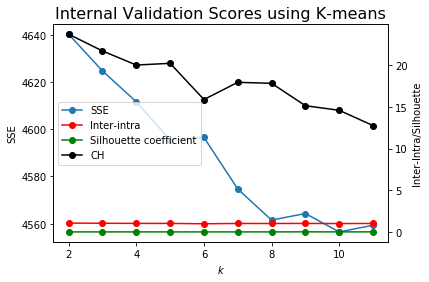

In [411]:
plt.plot(np.arange(2,12), inertias_ksvd, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(2,12), iidrs_ksvd, '-ro', label='Inter-intra')
plt.plot(np.arange(2,12), scs_ksvd, '-go', label='Silhouette coefficient')
plt.plot(np.arange(2,12), chs_ksvd, '-ko', label='CH')
plt.ylabel('Inter-Intra/Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.title("Internal Validation Scores using K-means",fontsize = 16)
plt.legend(lines+lines2, labels+labels2);

For K-means algorithm, it appears that the optimal value for **k is at 5**. The CH value is high at that point, and it is where the most elbowing happened for SSE.

#### K-Medians on SVD

In [160]:
inertias = []
iidrs = []
scs = []
chs = []

for i in range(2, 12):
    kmd = KMedians(k=i, random_state=1337)
    kmd.fit(X_svd)
    clusters = [ np.where(kmd.labels_==i)[0].tolist() for i in np.unique(kmd.labels_)]
    y = kmd.labels_
    centers = kmd.cluster_centers_
    inertias.append(sum([sum([cityblock(X_svd[point], center)**2 
                                      for point in points]) 
                               for points, center in zip(clusters, centers)]))
    iidrs.append(intra_to_inter(X_svd, y, cityblock, 500))
    if len(np.unique(kmd.labels_)) > 1:
        scs.append(silhouette_score(X_svd, y))
    else:
        scs.append(float('NaN'))
    chs.append(calinski_harabaz_score(X_svd, y))

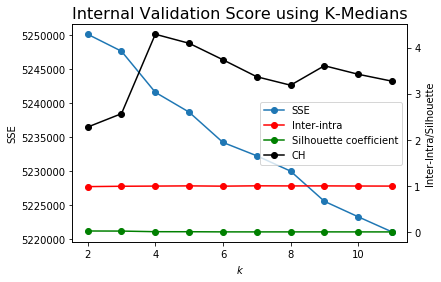

In [409]:
plt.plot(np.arange(2,12),inertias, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(2,12),iidrs, '-ro', label='Inter-intra')
plt.plot(np.arange(2,12), scs, '-go', label='Silhouette coefficient')
plt.plot(np.arange(2,12), chs, '-ko', label='CH')
plt.ylabel('Inter-Intra/Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.title("Internal Validation Score using K-Medians",fontsize = 16)
plt.legend(lines+lines2, labels+labels2);

For K-medians algorithm, it appears that the optimal value for **k is at 4**. The CH value is high at that point, and it is where the most elbowing, or greatest change in value happened for SSE. It is quite unfortunate though that the inter-intra ratios and silhouette coefficients appear to be constant in different values of k so we do not have much basis to use those validation metrics.

### Choosing K
Now, should we use 4 or 5 clusters? We checked at how the clusters fit when we use k = 4 and k = 5. The clusters appeared to be better distributed when we use 5 clusters. In k = 4, there are clusters with very little data, so we will use k = 5 instead under K-Means.

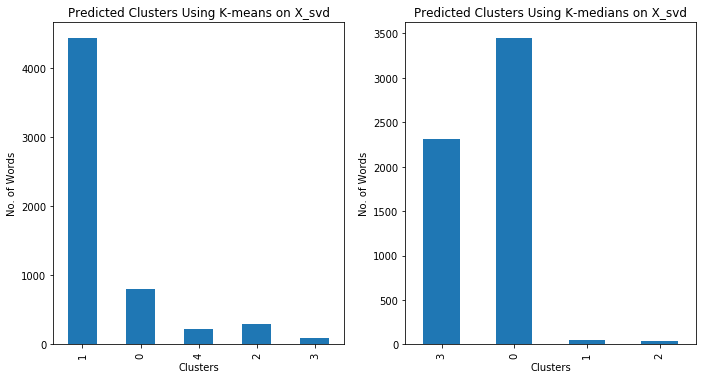

In [427]:
kmeans = KMeans(n_clusters=5, random_state=1337, n_jobs=-1)
y_predict = kmeans.fit_predict(X_svd)
kmedians = KMedians(k=4, random_state=1337)
kmedians = kmedians.fit(X_svd)
y_predict_kmd = kmedians.labels_

from collections import Counter
kmeans_count = Counter(y_predict)
df1 = pd.DataFrame.from_dict(kmeans_count, orient='index')

kmedians_count = Counter(y_predict_kmd)
df2 = pd.DataFrame.from_dict(kmedians_count, orient='index')

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
df1.plot(kind='bar',legend=False,ax=ax1)
ax1.set_title("Predicted Clusters Using K-means on X_svd")
ax1.set_ylabel('No. of Words')
ax1.set_xlabel('Clusters')

ax2 = fig.add_subplot(222)
df2.plot(kind='bar',legend=False,ax=ax2)
ax2.set_title("Predicted Clusters Using K-medians on X_svd")
ax2.set_ylabel('No. of Words')
ax2.set_xlabel('Clusters')
fig.tight_layout();

In the series of word clouds below, we will see the five clusters identified using K-Means. These will be further described in the results section of this report.

In [428]:
kmeans = KMeans(n_clusters=5, random_state=1337, n_jobs=-1)
y_predict = kmeans.fit_predict(bows)
reddit_data['Cluster'] = y_predict

**Cluster 1**

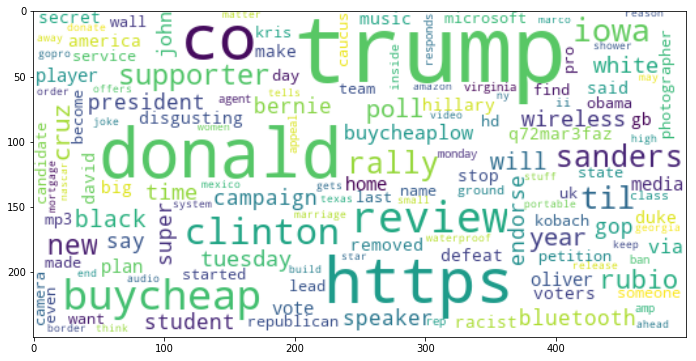

In [429]:
reddit_data_1 = reddit_data[reddit_data.Cluster == 0]
wordcloud_list_1 = []
for each in reddit_data_1['title'].dropna():
    temp = re.findall('\w[\w-]+', each)
    temp_list = []
    for why in temp:
        temp_list.append(re.sub('\s', '-', why))
    wordcloud_list_1 += temp_list

text = ' '.join(wordcloud_list_1)
wc = WordCloud(background_color="white", max_words=2000, 
               max_font_size=70, random_state=42, regexp='[^\s]+',
              min_font_size=8, width=500, height=250,
              collocations=False)
wc.generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.show()  

**Cluster 2**

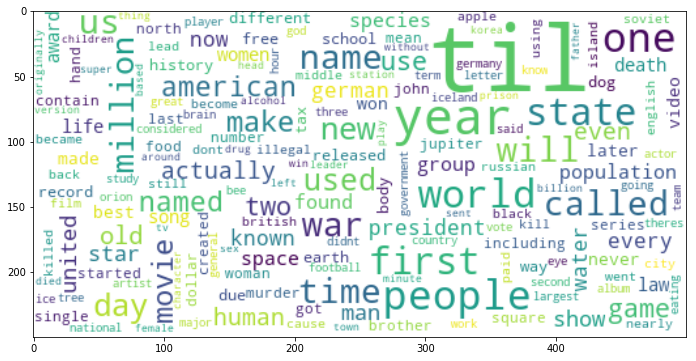

In [430]:
reddit_data_2 = reddit_data[reddit_data.Cluster == 1]
wordcloud_list_2 = []
for each in reddit_data_2['title'].dropna():
    temp = re.findall('\w[\w-]+', each)
    temp_list = []
    for why in temp:
        temp_list.append(re.sub('\s', '-', why))
    wordcloud_list_2 += temp_list

text = ' '.join(wordcloud_list_2)
wc = WordCloud(background_color="white", max_words=2000, 
               max_font_size=70, random_state=42, regexp='[^\s]+',
              min_font_size=8, width=500, height=250,
              collocations=False)
wc.generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.show()

**Cluster 3**

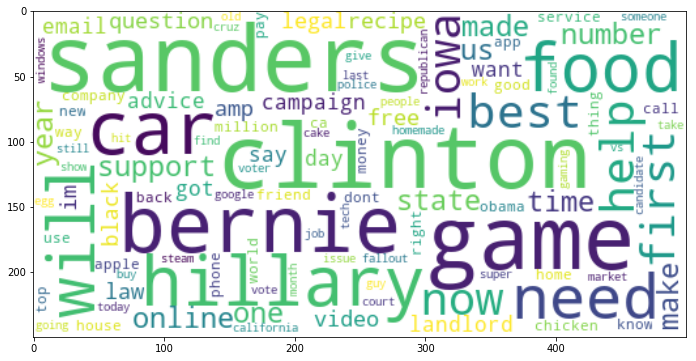

In [431]:
reddit_data_3 = reddit_data[reddit_data.Cluster == 2]
wordcloud_list_3 = []
for each in reddit_data_3['title'].dropna():
    temp = re.findall('\w[\w-]+', each)
    temp_list = []
    for why in temp:
        temp_list.append(re.sub('\s', '-', why))
    wordcloud_list_3 += temp_list

text = ' '.join(wordcloud_list_3)
wc = WordCloud(background_color="white", max_words=2000, 
               max_font_size=70, random_state=42, regexp='[^\s]+',
              min_font_size=8, width=500, height=250,
              collocations=False)
wc.generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.show()

**Cluster 4**

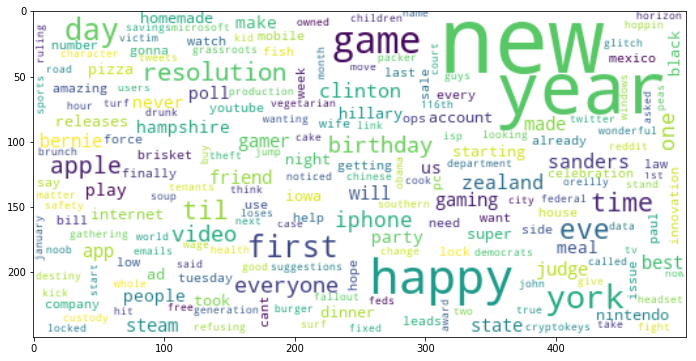

In [432]:
reddit_data_4 = reddit_data[reddit_data.Cluster == 3]
wordcloud_list_4 = []
for each in reddit_data_4['title'].dropna():
    temp = re.findall('\w[\w-]+', each)
    temp_list = []
    for why in temp:
        temp_list.append(re.sub('\s', '-', why))
    wordcloud_list_4 += temp_list

text = ' '.join(wordcloud_list_4)

wc = WordCloud(background_color="white", max_words=2000, 
               max_font_size=70, random_state=42, regexp='[^\s]+',
              min_font_size=8, width=500, height=250,
              collocations=False)
wc.generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.show()

**Cluster 5**

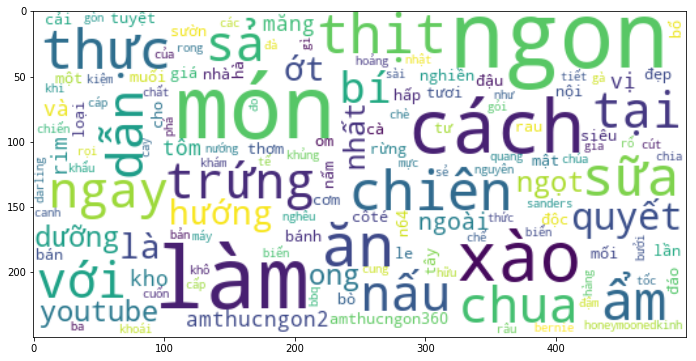

In [433]:
reddit_data_5 = reddit_data[reddit_data.Cluster == 4]
wordcloud_list_5 = []
for each in reddit_data_5['title'].dropna():
    temp = re.findall('\w[\w-]+', each)
    temp_list = []
    for why in temp:
        temp_list.append(re.sub('\s', '-', why))
    wordcloud_list_5 += temp_list
text = ' '.join(wordcloud_list_5)

wc = WordCloud(background_color="white", max_words=2000, 
               max_font_size=70, random_state=42, regexp='[^\s]+',
              min_font_size=8, width=500, height=250,
              collocations=False)
wc.generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.show()

## Results and Recommendations

Based on the results of the k-means clustering, we have clustered the Reddit post titles into five groups. Detailed explanation of the clusters are as follows:
- **Cluster 1:** This cluster mostly talks about the 2016 US Presidential Elections where Donald Trump won. The cluster also includes some words like "black", "disgusting" and "rally" which could be related to the sentiments of some people towards Trump's remarks and the Republican party in general.
- **Cluster 2:** This is the TIL or Today I Learned Cluster. Topics here are mostly random and contains post titles about discoveries or learning a new knowledge and something interesting. 
- **Cluster 3:** The cluster here are mostly topics related to the US Democratic Party, particularly those related to Hilary Clinton and Bernie Sanders. Another word that frequently appear here is 'iowa' which is one of the swing states in the last US Presidential Elections.
- **Cluster 4:** This cluster is mostly about leisure or celebrations. The most frequent words that appear are "new", "year" and "happy".
- **Cluster 5:** This cluster are foreign words, with Vietnamese words appearing mostly. This appears to be the most well clustered group.

Looking more closely at the word clouds above may reveal that some of the words are not really much related to the identified themes or topics. As such, it is possible to explore other clustering algorithms and other validation metrics which may result to a more optimal k that are better clustered. In particular, changing the n-gram parameter to (1,2) or (1,3) can also be explored to make more meaning and context to the data being analyzed.

## References
1. Alis, Christian (2019). Representative-based clustering Notebook.
2. Manasan, Patricia and Mendoza, Accever (2018). Theme Extraction and Clustering of Boardgames.
3. Alba, Tristan and Colipapa, Jon (2018). Internet-based Sentiment Analysis for Trading.
4. https://en.wikipedia.org/wiki/K-medians_clustering
5. https://en.wikipedia.org/wiki/Tf%E2%80%93idf
6. https://en.wikipedia.org/wiki/Reddit
7. https://www.lifewire.com/what-does-til-stand-for-at-reddit-2483374

## Acknowledgements
1. Jonathan Uy
2. Daryll Carrasco

## Git Repository Link
Not included for anonymity